# Reprojecting to other coordinate system:

## Setting up:

In [1]:
# run script that installs missing libraries
#! chmod 755 ../scripts.sh
#! ../scripts.sh

### Imports

In [2]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs

import pyproj
from pyproj import Transformer
from google.cloud import storage


# Functions: 
from process_pangeo import *
from reprojectionFunctions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
# Google cloud info
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

## Read data

### GCM:

In [4]:
# Connect to Google Cloud Storage
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Read catalogue
df = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip5.csv")

# Create dataframe from function:
dg = createGCM_Pangeo(df,fs)
dg

Experiments:
---------------------
['1pctCO2' 'abrupt-4xCO2' 'rcp85' 'historical' 'piControl']
Member ids:
---------------------
['r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1']


<xarray.Dataset>
Dimensions:    (lat: 145, bnds: 2, lon: 192, time: 3012)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.38 -89.38 ... 89.38 89.38 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    lon_bnds   (lon, bnds) float64 -0.9375 0.9375 0.9375 ... 357.2 357.2 359.1
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1872, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    psl        (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    uas        (time, lat, lon) float32 dask.array<chunksize=(451, 145, 192), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    rlut       (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    rsdt       (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
    vas        (time, lat, lon) float32 dask.array<chunksize=(451, 145, 192), meta=np.ndarray>
    rsut       (time, lat, lon) float32 dask.array<chunksize=(448, 145, 192), meta=np.ndarray>
Attributes: (12/28)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    references:             See http://wiki.csiro.au/confluence/display/ACCES...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413

#### Define antarctica region

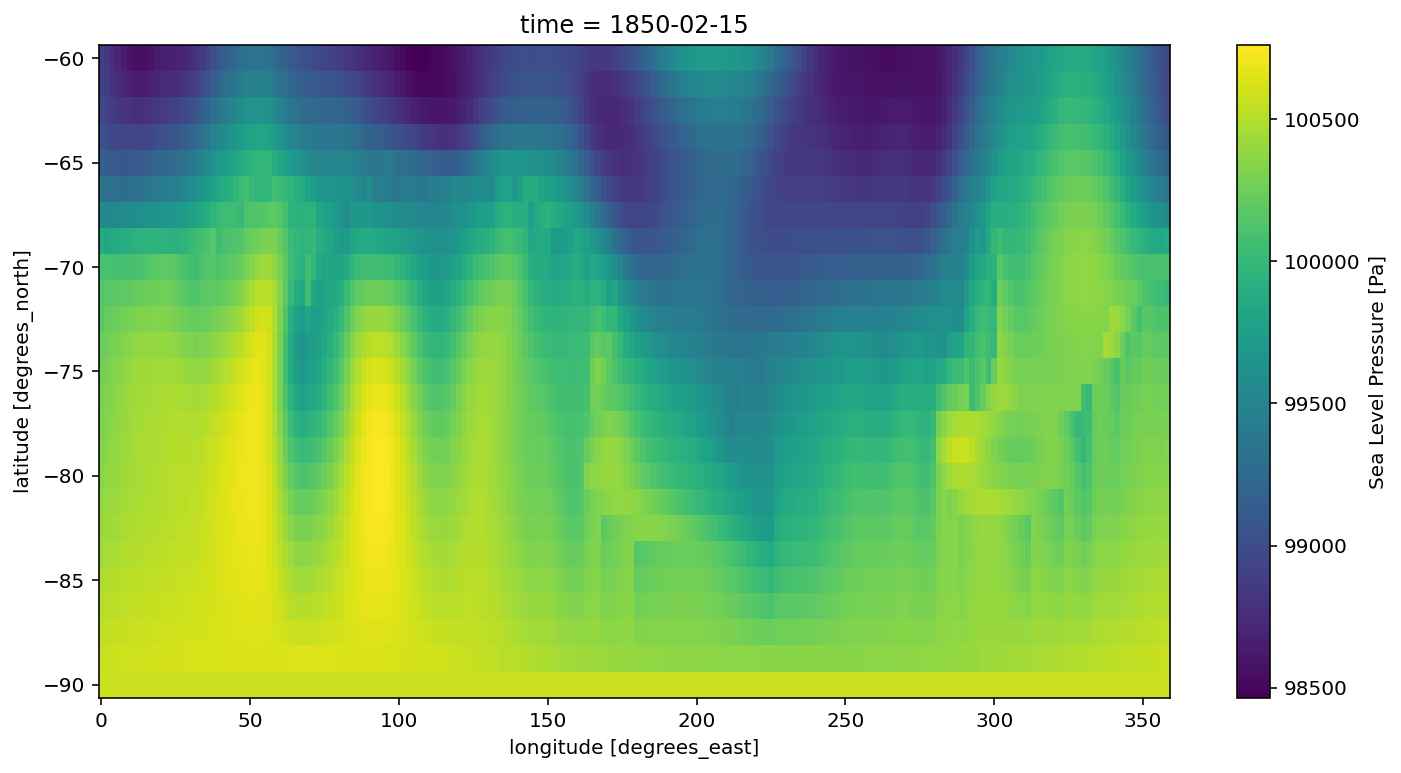

In [5]:
# define antarctica as 90° S to 60° S in latitude and full longitude
nlimit=-60
lat = dg.lat.sel(lat=slice(-90,nlimit))
lon = dg.lon

antarctica = dg.sel(lat=slice(-90,nlimit))
antarctica.psl.isel(time=1).plot(x="lon")

In [6]:
# Define GCM
GCM = antarctica.sortby(["lat", "lon","time"])

print('[GCM original] lon: {}° -> {}° and lat: {}° -> {}°'.format(GCM.lon.min().data, 
                                                                     GCM.lon.max().data, 
                                                                     GCM.lat.min().data, 
                                                                     GCM.lat.max().data))
GCM.load()

[GCM original] lon: 0.0° -> 358.125° and lat: -90.0° -> -60.0°


<xarray.Dataset>
Dimensions:    (lat: 25, bnds: 2, lon: 192, time: 3012)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... -62.5 -61.25 -60.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.38 -89.38 ... -60.62 -60.62 -59.38
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    lon_bnds   (lon, bnds) float64 -0.9375 0.9375 0.9375 ... 357.2 357.2 359.1
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] 1850-01-01 1850-02-01 ... 2101-01-01
Dimensions without coordinates: bnds
Data variables:
    psl        (time, lat, lon) float32 9.965e+04 9.965e+04 ... 9.945e+04
    uas        (time, lat, lon) float32 nan nan nan nan ... 6.144 5.938 5.729
    pr         (time, lat, lon) float32 1.484e-06 1.484e-06 ... 1.959e-05
    rlut       (time, lat, lon) float32 182.0 182.0 182.0 ... 214.9 214.3 213.0
    tas        (time, lat, lon) float32 240.8 240.8 240.8 ... 272.6 272.6 272.6
    rsdt       (time, lat, lon) float32 498.2 498.2 498.2 ... 504.3 504.3 504.3
    vas        (time, lat, lon) float32 nan nan nan nan ... 0.4359 0.7419 1.026
    rsut       (time, lat, lon) float32 359.7 359.7 359.7 ... 187.8 189.4 187.7
Attributes: (12/28)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    references:             See http://wiki.csiro.au/confluence/display/ACCES...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413

### RCM:

In [7]:
# RH
# open from google cloud
pathRCM = 'ee-downscalingclimatemodels/Chris_data/RawData/MAR-ACCESS1.3/zarr_data/'

var = 'CC'
path_RCM_decades= pathRCM+f'{var}_zarr/'
path_RCM_var = path_RCM_decades+f'{var}_decade_1.zarr'

dsr = xr.open_zarr('gs://'+path_RCM_var, decode_times=True)
dates = pd.DatetimeIndex(dsr.TIME.values)
print('Unique years in the dataset:', dates.year.unique().values)

RCM = dsr.rename({'X':'x', 'Y':'y','TIME':'time'})
RCM_xy = RCM.rio.write_crs("epsg:3031")

# Convert RCM from km to m for plots:
RCM_xy['x'] = RCM_xy.x*1000
RCM_xy['y'] = RCM_xy.y*1000
RCM_xy.x.attrs['units'] = 'm'
RCM_xy.y.attrs['units'] = 'm'

print('Max and min values of x: {}m -> {}m and y: {}m -> {}m'.format(RCM_xy.x.max().data, 
                                                                     RCM_xy.x.min().data, 
                                                                     RCM_xy.y.max().data, 
                                                                     RCM_xy.y.min().data))
RCM_xy.load()

Unique years in the dataset: [1980 1981 1982 1983 1984 1985 1986 1987 1988 1989]
Max and min values of x: 3115000.0m -> -3010000.0m and y: 2590000.0m -> -2555000.0m


<xarray.Dataset>
Dimensions:      (time: 3653, y: 148, x: 176, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01T12:00:00 ... 1989-12-31T12:...
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Dimensions without coordinates: bnds
Data variables:
    CC           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TIME_bnds    (time, bnds) datetime64[ns] 1980-01-01 ... 1990-01-01
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    CDO:                            Climate Data Operators version 1.9.7.1 (h...
    CORDEX_domain:                  ant-35km
    Conventions:                    CF-1.6
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    contact:                        ckittel@uliege.be
    ...                             ...
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model:                          regional climate model MARv3.10
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

## Transform GCM lat/lon -> x/y:

Want to downsample RCM grid so that it goes from resolution of 35km to 150km

### Create downsampled RCM grid:
To change GCM resolution from degrees to km use formula:

x = deg_lon * distance between lon lines at point

y = deg_lat * distance between lat lines at point

Take d(lon) at -60°lat is 55km and d(lat) at -60°lat is 110km ([Link](https://stevemorse.org/nearest/distance.php))

Then x = 68km and y = 206km

In [8]:
# Create downsampled RCM grid on which we'll interpolate GCM
pathRCM = 'ee-downscalingclimatemodels/Chris_data/RawData/MAR-ACCESS1.3/zarr_data/'
gridx, gridy = create_downs_RCMgrid(pathRCM)

Original RCM grid:
----------------------
Max and min values of x: -3010.00km -> 3115.00km and y: -2555.00km -> 2590.00km
shape: (148, 176)
resolution: (35.0, 35.0)
bounds: (-3027.5, 2607.5, 3132.5, -2572.5)
CRS: None

Downsample to new resolution:
----------------------
Max and min values of x: -5848.00km -> 6052.00km and y: -15038.00km -> 15244.00km
shape: (148, 176)
resolution: (68.0, 205.99998671343536)
bounds: (-5882.0, 15346.999016794218, 6086.0, -15140.999016794218)
CRS: None

Cut so that on original x,y bounds:
--------------------------
Max and min values of x: -2992.00km -> 3060.00km and y: -2472.00km -> 2472.00km
New grid shape (gridx, gridy): (90,) (25,)


### Interpolate GCM on downsampled RCM grid:

In [9]:
print('\n---------------------------------\nRight part:\n---------------------------------\n')
GCM_xy_right = InterpolateGCM(GCM, RCM_xy, gridx, gridy, left = False)
print('\n---------------------------------\nLeft part:\n---------------------------------\n')
GCM_xy_left = InterpolateGCM(GCM, RCM_xy, gridx, gridy, left = True)

# Assemble two parts:
GCM_xy = GCM_xy_right.merge(GCM_xy_left)


---------------------------------
Right part:
---------------------------------

Shape of GCM data: time: 3012, lat: 25, lon: 192
-----------------
Shape of RCM data: time: 3653, y: 148, x: 176
-----------------
Mesh shapes: (25, 90), (25, 90)
Lat-lon mesh:
-----------------
Max and min values of lat: -90.00° -> -54.89° and lon: -178.42° -> 180.00°

Interpolate:

GCM before interpolation:
-----------------
Max and min values of lat: -90.00° -> -60.00° and lon: 0.00° -> 358.12°

GCM after interpolation
-----------------
Max and min values of lat: -90.00° -> -54.89° and lon: -178.42° -> 180.00°

Replace coordinates by new coordinates:

---------------------------------
Left part:
---------------------------------

After transf
Max and min values of lat: -90.00° -> -60.00° and lon: -180.00° -> 178.12°
Shape of GCM data: time: 3012, lat: 25, lon: 192
-----------------
Shape of RCM data: time: 3653, y: 148, x: 176
-----------------
Mesh shapes: (25, 90), (25, 90)
Lat-lon mesh:
------------

In [10]:
GCM_xy.load()

<xarray.Dataset>
Dimensions:      (y: 25, x: 90, bnds: 2, time: 3012)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Dimensions without coordinates: bnds
Data variables:
    lat_bnds     (y, x, bnds) float64 nan nan nan nan nan ... nan nan nan nan
    lon_bnds     (y, x, bnds) float64 229.7 231.6 229.7 ... 51.56 49.69 51.56
    psl          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    time_bnds    (time, bnds) datetime64[ns] 1850-01-01 ... 2101-01-01
    uas          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    pr           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    rlut         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tas          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    rsdt         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    vas          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    rsut         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    spatial_ref  int64 0
Attributes: (12/29)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413
    crs:                    epsg:4326

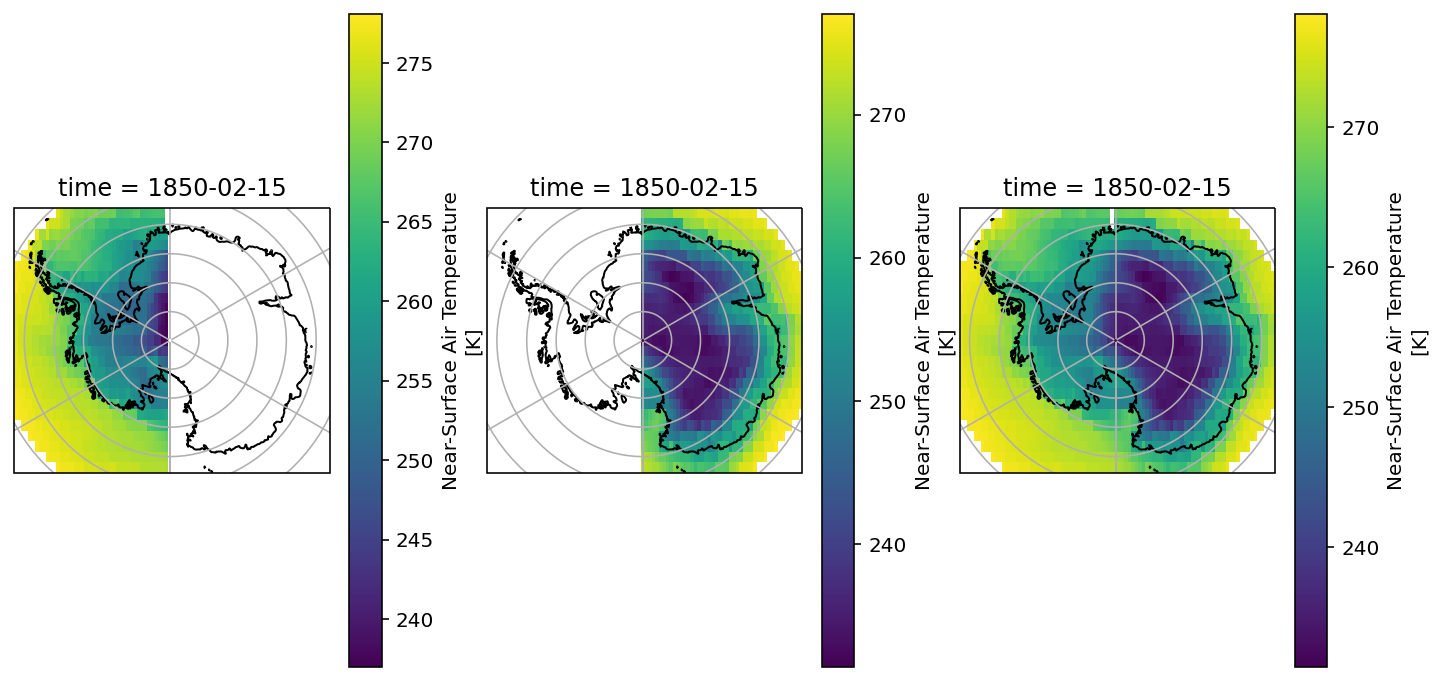

In [11]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax =plt.subplot(1,3,2,projection=map_proj)
GCM_xy_right.tas.isel(time = 1).plot(ax=ax, x='x', y='y', 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax =plt.subplot(1,3,1,projection=map_proj)
GCM_xy_left.tas.isel(time = 1).plot(ax=ax, x='x', y='y', 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax =plt.subplot(1,3,3,projection=map_proj)
GCM_xy.tas.isel(time = 1).plot(ax=ax, x='x', y='y', 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

### Save new projection to GC

In [12]:
# Save file
savePath = 'ee-downscalingclimatemodels/Chris_data/RawData/MAR-ACCESS1.3/monthly/month_ACCESS1-3-stereographic.zarr'        
GCM_xy.attrs['crs'] = 3031
GCM_xy.to_zarr('gs://'+savePath, mode = 'w')

## GCM-like outputs:
### GCM xy:
GCM interpolated in polar stereographic coordinates

Text(0.5, 0.98, 'First time step (first month) of GCM_xy')

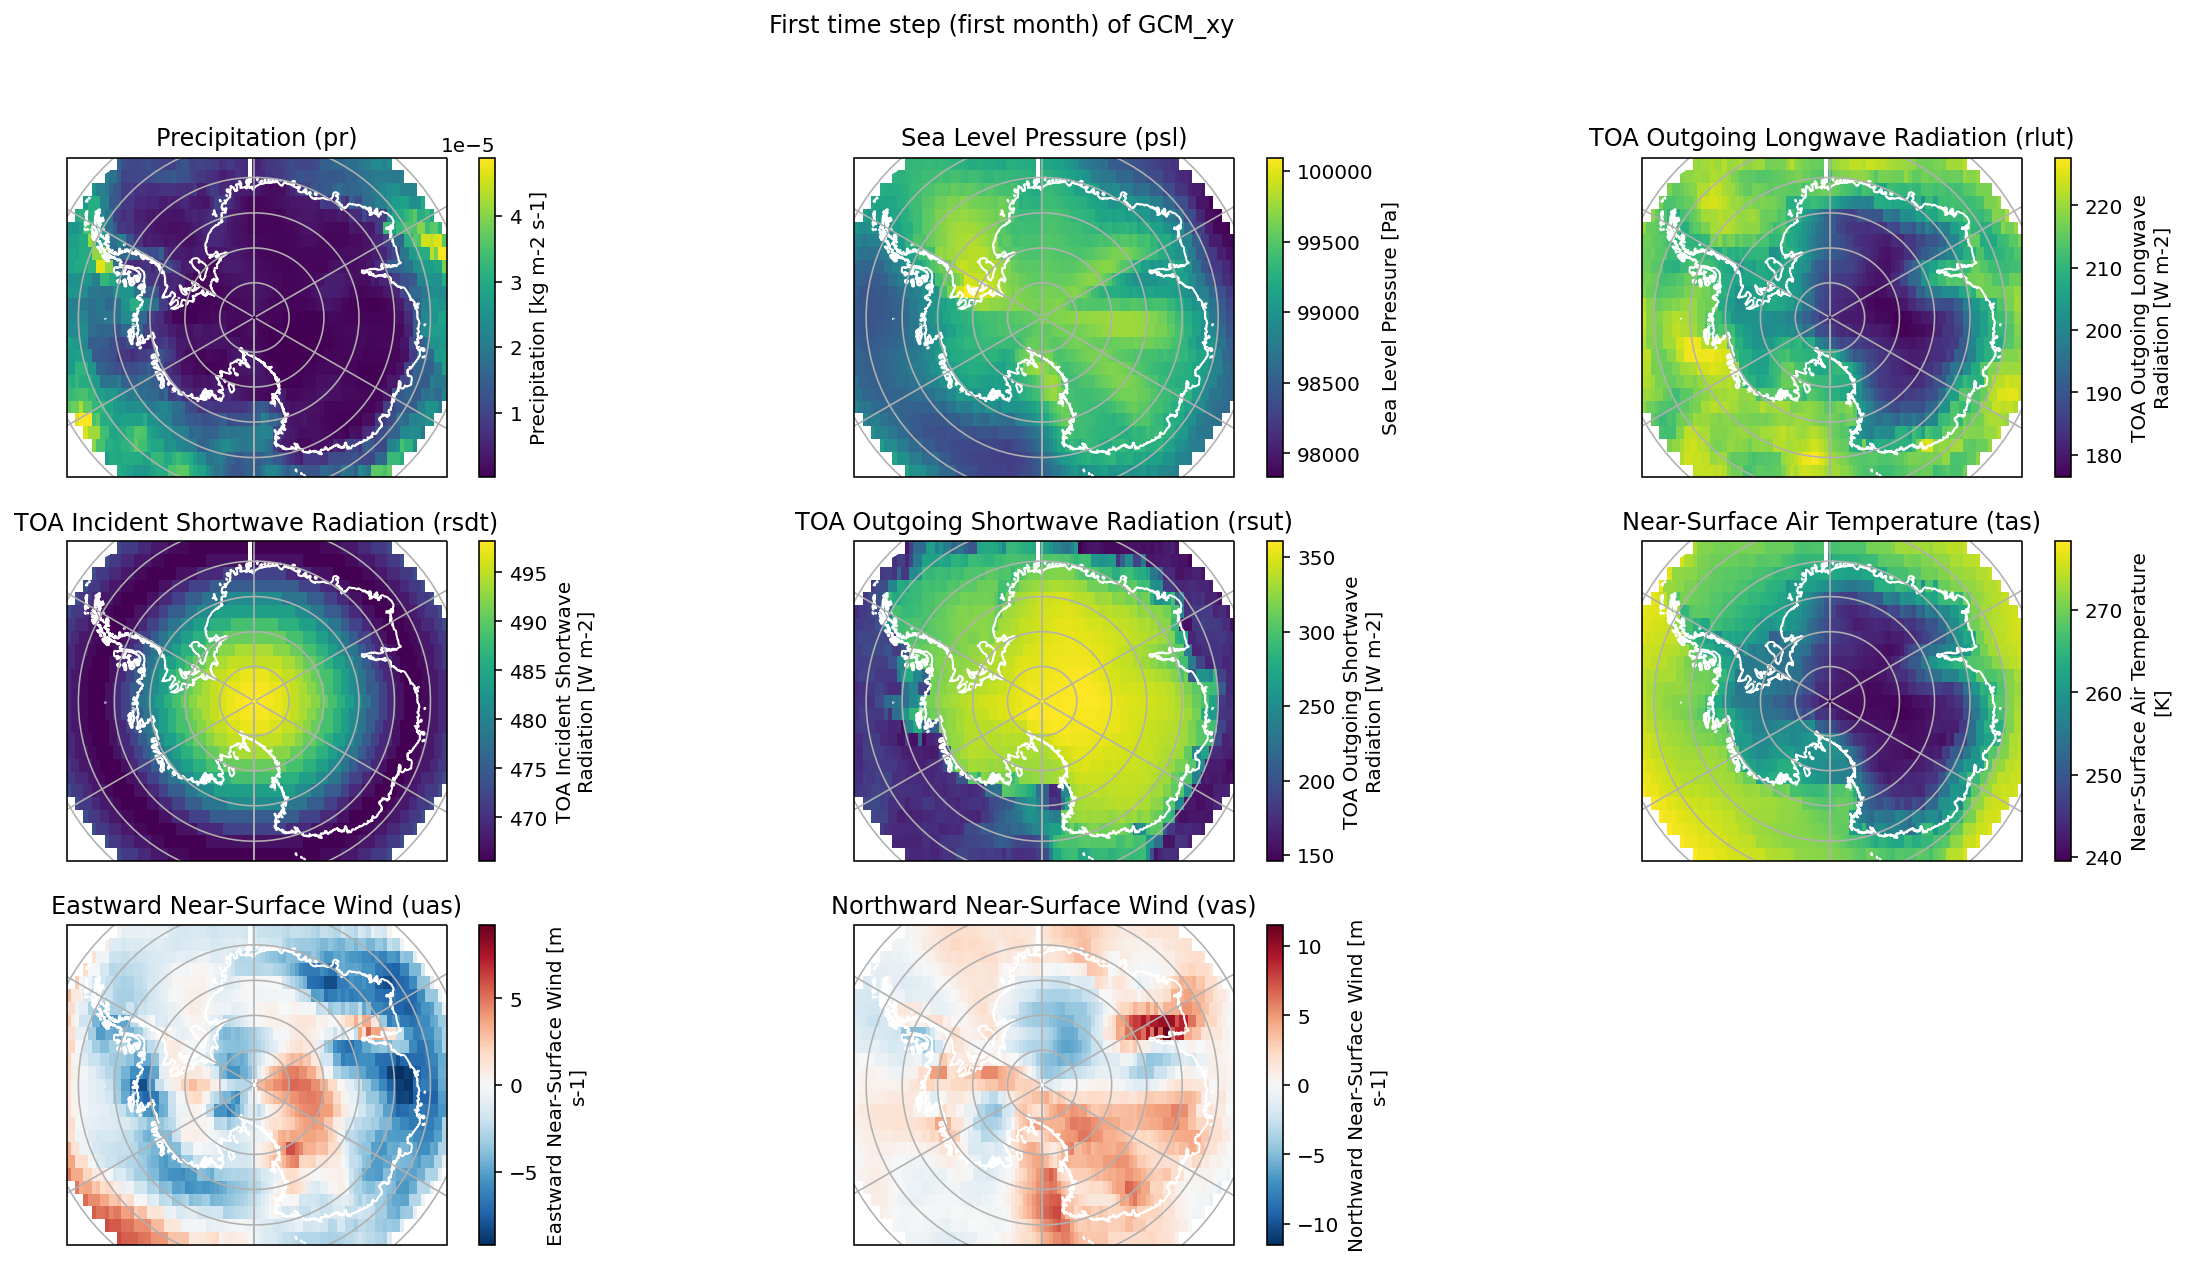

In [13]:
# open from google cloud
globalName = 'ee-downscalingclimatemodels/Chris_data/RawData/MAR-ACCESS1.3/monthly/month_ACCESS1-3-stereographic.zarr'    
GCM_xy = xr.open_zarr('gs://'+globalName)
GCM_xy = GCM_xy.rio.write_crs("epsg:3031")
GCM_xy.attrs['crs'] = 3031

GCM_xy_plot = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds'])
vars_ = list(GCM_xy_plot.data_vars)
coords = list(GCM_xy_plot.coords)

f = plt.figure(figsize=(20,10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(3,3,i+1,projection=ccrs.SouthPolarStereo())
    GCM_xy_plot[var].isel(time = 0).plot(ax=ax, 
                    x='x', y='y', 
                    transform=ccrs.SouthPolarStereo(),
                    add_colorbar=True
                   )
    ax.coastlines('10m', color='w')
    ax.gridlines()
    ax.set_title(f'{GCM_xy[var].long_name} ({var})')
plt.suptitle('First time step (first month) of GCM_xy')

### RCM xy: 
RCM dataset with polar stereographic coordinates:

In [14]:
# RH
# open from google cloud
pathRCM = 'ee-downscalingclimatemodels/Chris_data/RawData/MAR-ACCESS1.3/zarr_data/'

#vars_ = ['RH', 'RU', 'VVP', 'UUP', 'LWD', 'ME','CC']
vars_ = ['RH', 'RU', 'VVP', 'LWD', 'ME','CC']

# Open first decade of all variables available:
firstVar = path_RCM_decades= pathRCM+f'{vars_[0]}_zarr/'
path_RCM_var = path_RCM_decades+f'{vars_[0]}_decade_1.zarr'
dsr = xr.open_zarr('gs://'+path_RCM_var, decode_times=True)

for var in vars_[1:]:
    print(var)
    path_RCM_decades= pathRCM+f'{var}_zarr/'
    path_RCM_var = path_RCM_decades+f'{var}_decade_1.zarr'
    df = xr.open_zarr('gs://'+path_RCM_var, decode_times=True)    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        dsr = df.merge(dsr)

RCM = dsr.rename({'X':'x', 'Y':'y','TIME':'time'})

# indicate projection crs
RCM_xy = RCM.rio.write_crs("epsg:3031")

# Convert RCM from km to m for plots:
RCM_xy['x'] = RCM_xy.x*1000
RCM_xy['y'] = RCM_xy.y*1000
RCM_xy.x.attrs['units'] = 'm'
RCM_xy.y.attrs['units'] = 'm'

# Remove SECTOR dimension:
dim = ('time', 'y', 'x')
RCM_xy_plot = RCM_xy.copy()
RCM_xy_plot['ME'] = xr.Variable(dims = dim, 
                            data = RCM_xy_plot.ME.mean(dim='SECTOR1_1'), 
                            attrs = RCM_xy_plot.ME.attrs)
RCM_xy_plot['RU'] = xr.Variable(dims = dim, 
                           data = RCM_xy_plot.RU.mean(dim='SECTOR'), 
                           attrs = RCM_xy_plot.RU.attrs)
RCM_xy_plot['RH'] = xr.Variable(dims = dim, 
                           data = RCM_xy_plot.RH.mean(dim='ATMLAY'), 
                           attrs = RCM_xy_plot.RH.attrs)
RCM_xy_plot['VVP'] = xr.Variable(dims = dim, 
                            data = RCM_xy_plot.VVP.mean(dim='PLEV'), 
                            attrs = RCM_xy_plot.VVP.attrs)

# drop irrelevant sector dimension
RCM_xy_plot = RCM_xy_plot.drop_dims(['SECTOR1_1', 'SECTOR', 'ATMLAY'])
RCM_xy_plot = RCM_xy_plot.drop(['TIME_bnds', 'PLEV_bnds','PLEV'])
RCM_xy_plot

RU
VVP
LWD
ME
CC


<xarray.Dataset>
Dimensions:      (time: 3653, y: 148, x: 176)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01T12:00:00 ... 1989-12-31T12:...
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Data variables:
    CC           (time, y, x) float32 dask.array<chunksize=(457, 19, 44), meta=np.ndarray>
    ME           (time, y, x) float32 dask.array<chunksize=(457, 19, 44), meta=np.ndarray>
    LWD          (time, y, x) float32 dask.array<chunksize=(457, 19, 44), meta=np.ndarray>
    VVP          (time, y, x) float32 dask.array<chunksize=(457, 37, 44), meta=np.ndarray>
    RU           (time, y, x) float32 dask.array<chunksize=(457, 19, 44), meta=np.ndarray>
    RH           (time, y, x) float32 dask.array<chunksize=(457, 37, 44), meta=np.ndarray>
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    CDO:                            Climate Data Operators version 1.9.7.1 (h...
    CORDEX_domain:                  ant-35km
    Conventions:                    CF-1.6
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    contact:                        ckittel@uliege.be
    ...                             ...
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model:                          regional climate model MARv3.10
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

Text(0.5, 0.98, 'First time step (day) of RCM xy')

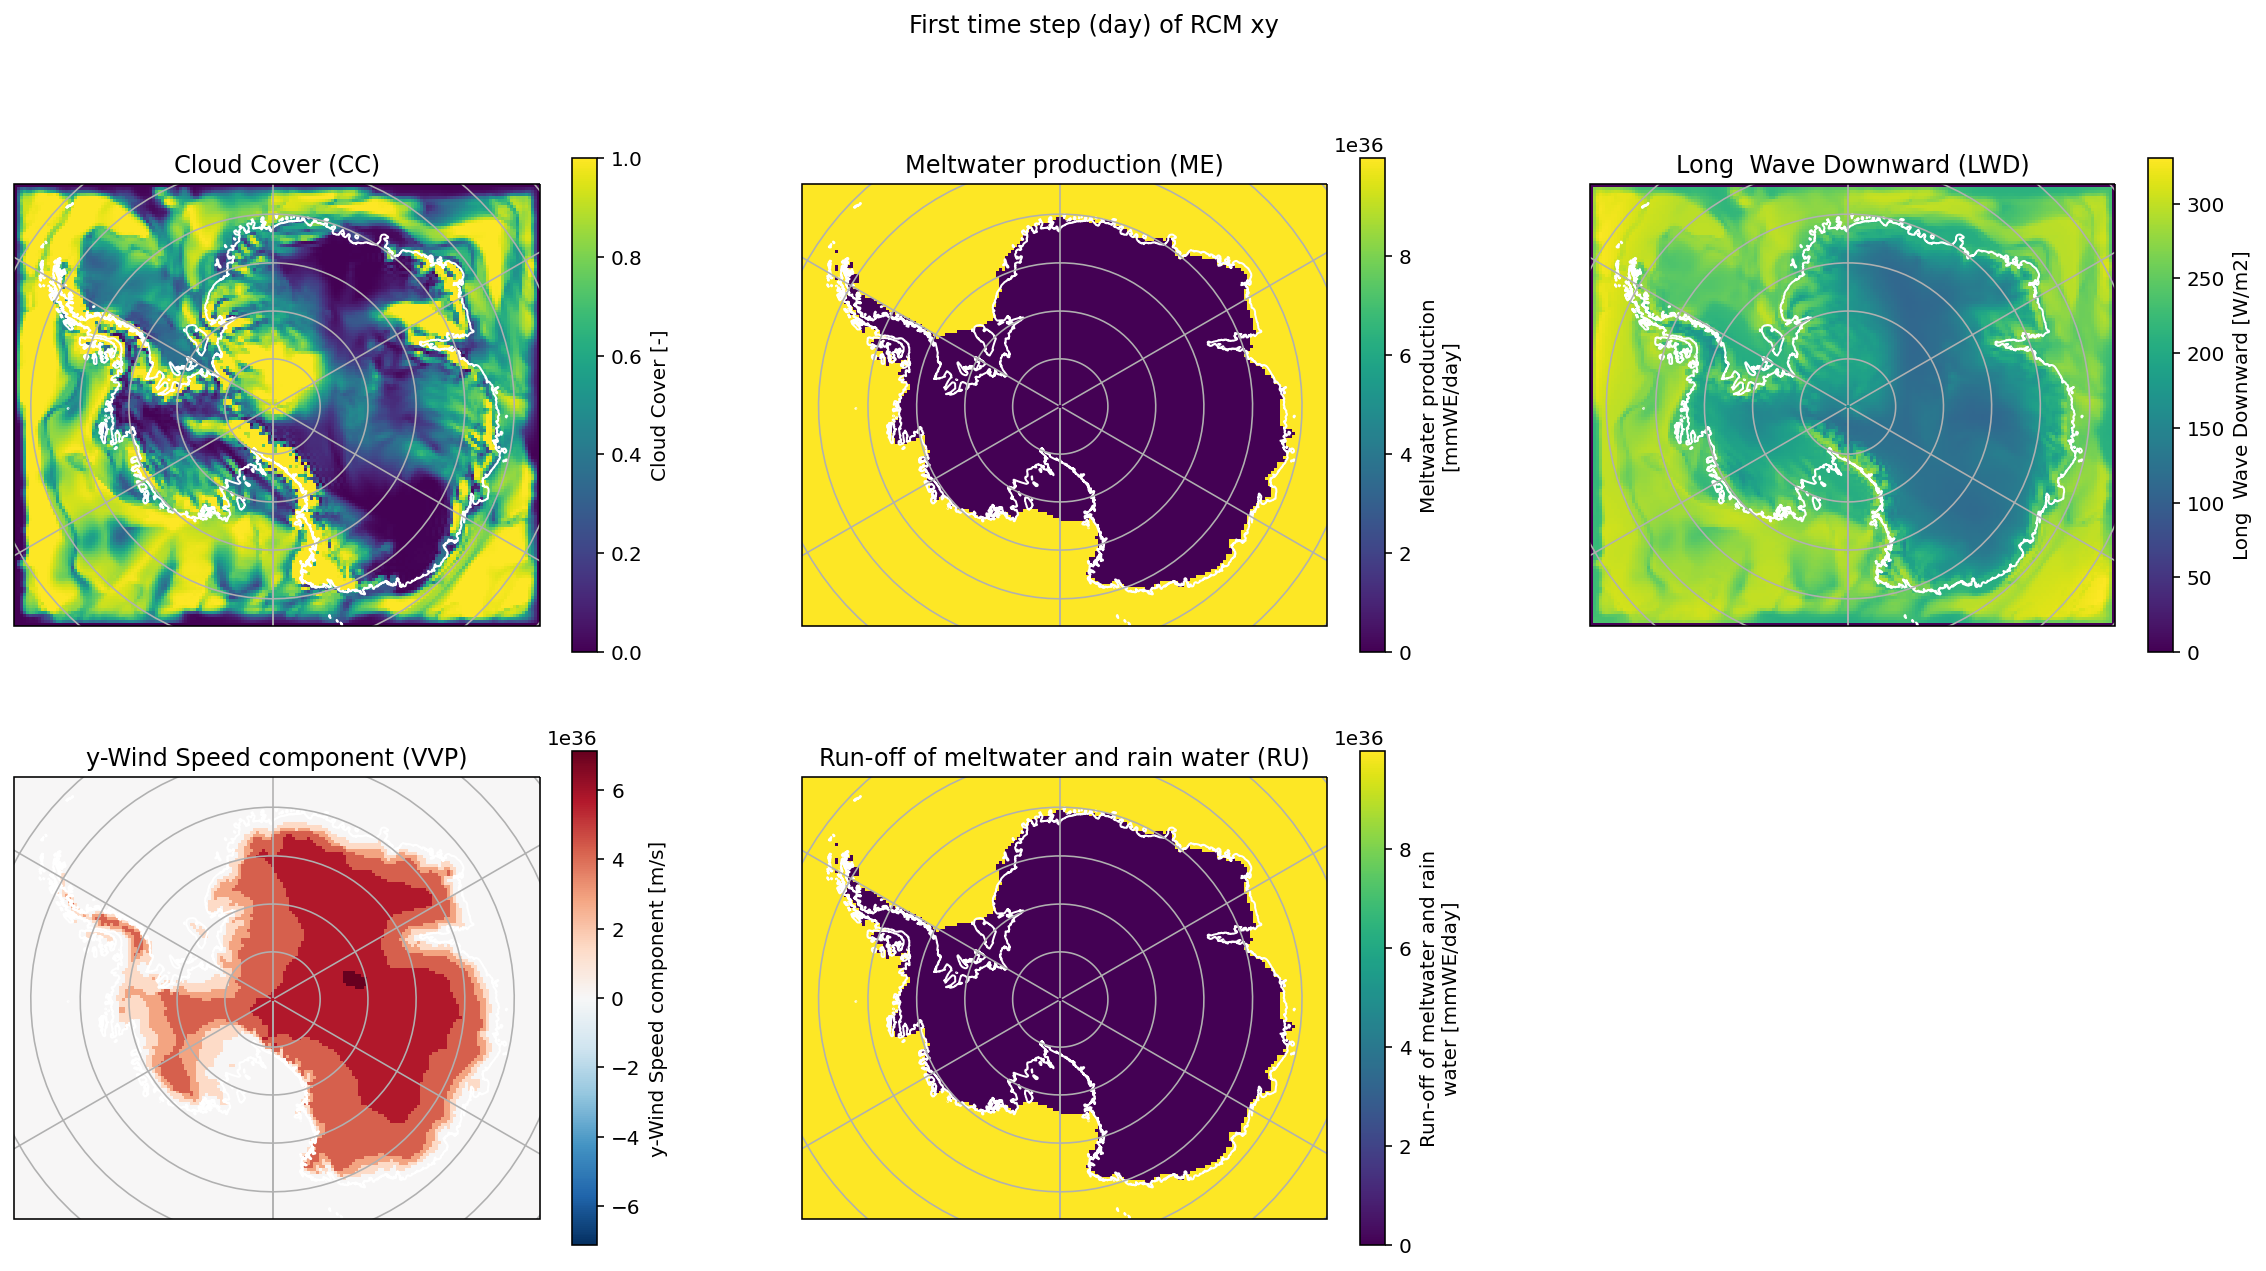

In [15]:
vars_ = list(RCM_xy_plot.keys())[:-1]
coords = list(RCM_xy_plot.coords)

f = plt.figure(figsize=(20,10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(2,3,i+1,projection=ccrs.SouthPolarStereo())
    RCM_xy_plot[var].isel(time = 0).plot(ax=ax, 
                    x='x', y='y', 
                    transform=ccrs.SouthPolarStereo(),
                    add_colorbar=True
                   )
    ax.coastlines('10m', color='w')
    ax.set_title(f'{RCM_xy_plot[var].long_name} ({var})')
    ax.gridlines()
plt.suptitle('First time step (day) of RCM xy')

In [16]:
# Compare resolutions
print("GCM with crs x/y:\n----------------\n")
print_raster(GCM_xy.tas)
print("RCM with crs x/y:\n----------------\n")
print_raster(RCM_xy.CC)

GCM with crs x/y:
----------------

shape: (25, 90)
resolution: (68000.0, 206000.0)
bounds: (-3026000.0, 2575000.0, 3094000.0, -2575000.0)
CRS: EPSG:3031

RCM with crs x/y:
----------------

shape: (148, 176)
resolution: (35000.0, 35000.0)
bounds: (-3027500.0, 2607500.0, 3132500.0, -2572500.0)
CRS: EPSG:3031



### Reproject RCM xy on GCM xy grid:
Creates fake GCM like outputs from RCM

In [17]:
# Reproject
vars_ = list(RCM_xy_plot.keys())
GCM_like = xr.Dataset()
dim = ('time', 'y', 'x')
for var in vars_:
    GCM_like[var] = xr.Variable(dims = dim, 
                                data = RCM_xy_plot[var].rio.reproject_match(GCM_xy.tas), 
                                attrs = RCM_xy_plot[var].attrs)
GCM_like = GCM_like.assign_coords(RCM_xy_plot[var].rio.reproject_match(GCM_xy.tas).coords)
GCM_like

<xarray.Dataset>
Dimensions:      (time: 3653, y: 25, x: 90)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-01T12:00:00 ... 1989-12-31T12:...
Data variables:
    CC           (time, y, x) float32 0.00193 0.004109 ... 0.04675 0.02136
    ME           (time, y, x) float32 9.969e+36 9.969e+36 ... 9.969e+36
    LWD          (time, y, x) float32 231.9 232.4 233.6 ... 222.4 223.0 221.7
    VVP          (time, y, x) float32 -1.765 -1.763 -1.62 ... -2.917 -3.67
    RU           (time, y, x) float32 9.969e+36 9.969e+36 ... 9.969e+36
    RH           (time, y, x) float32 72.68 75.58 77.39 ... 80.84 81.03 80.39

Text(0.5, 0.98, 'First time step of GCM_like RCM xy')

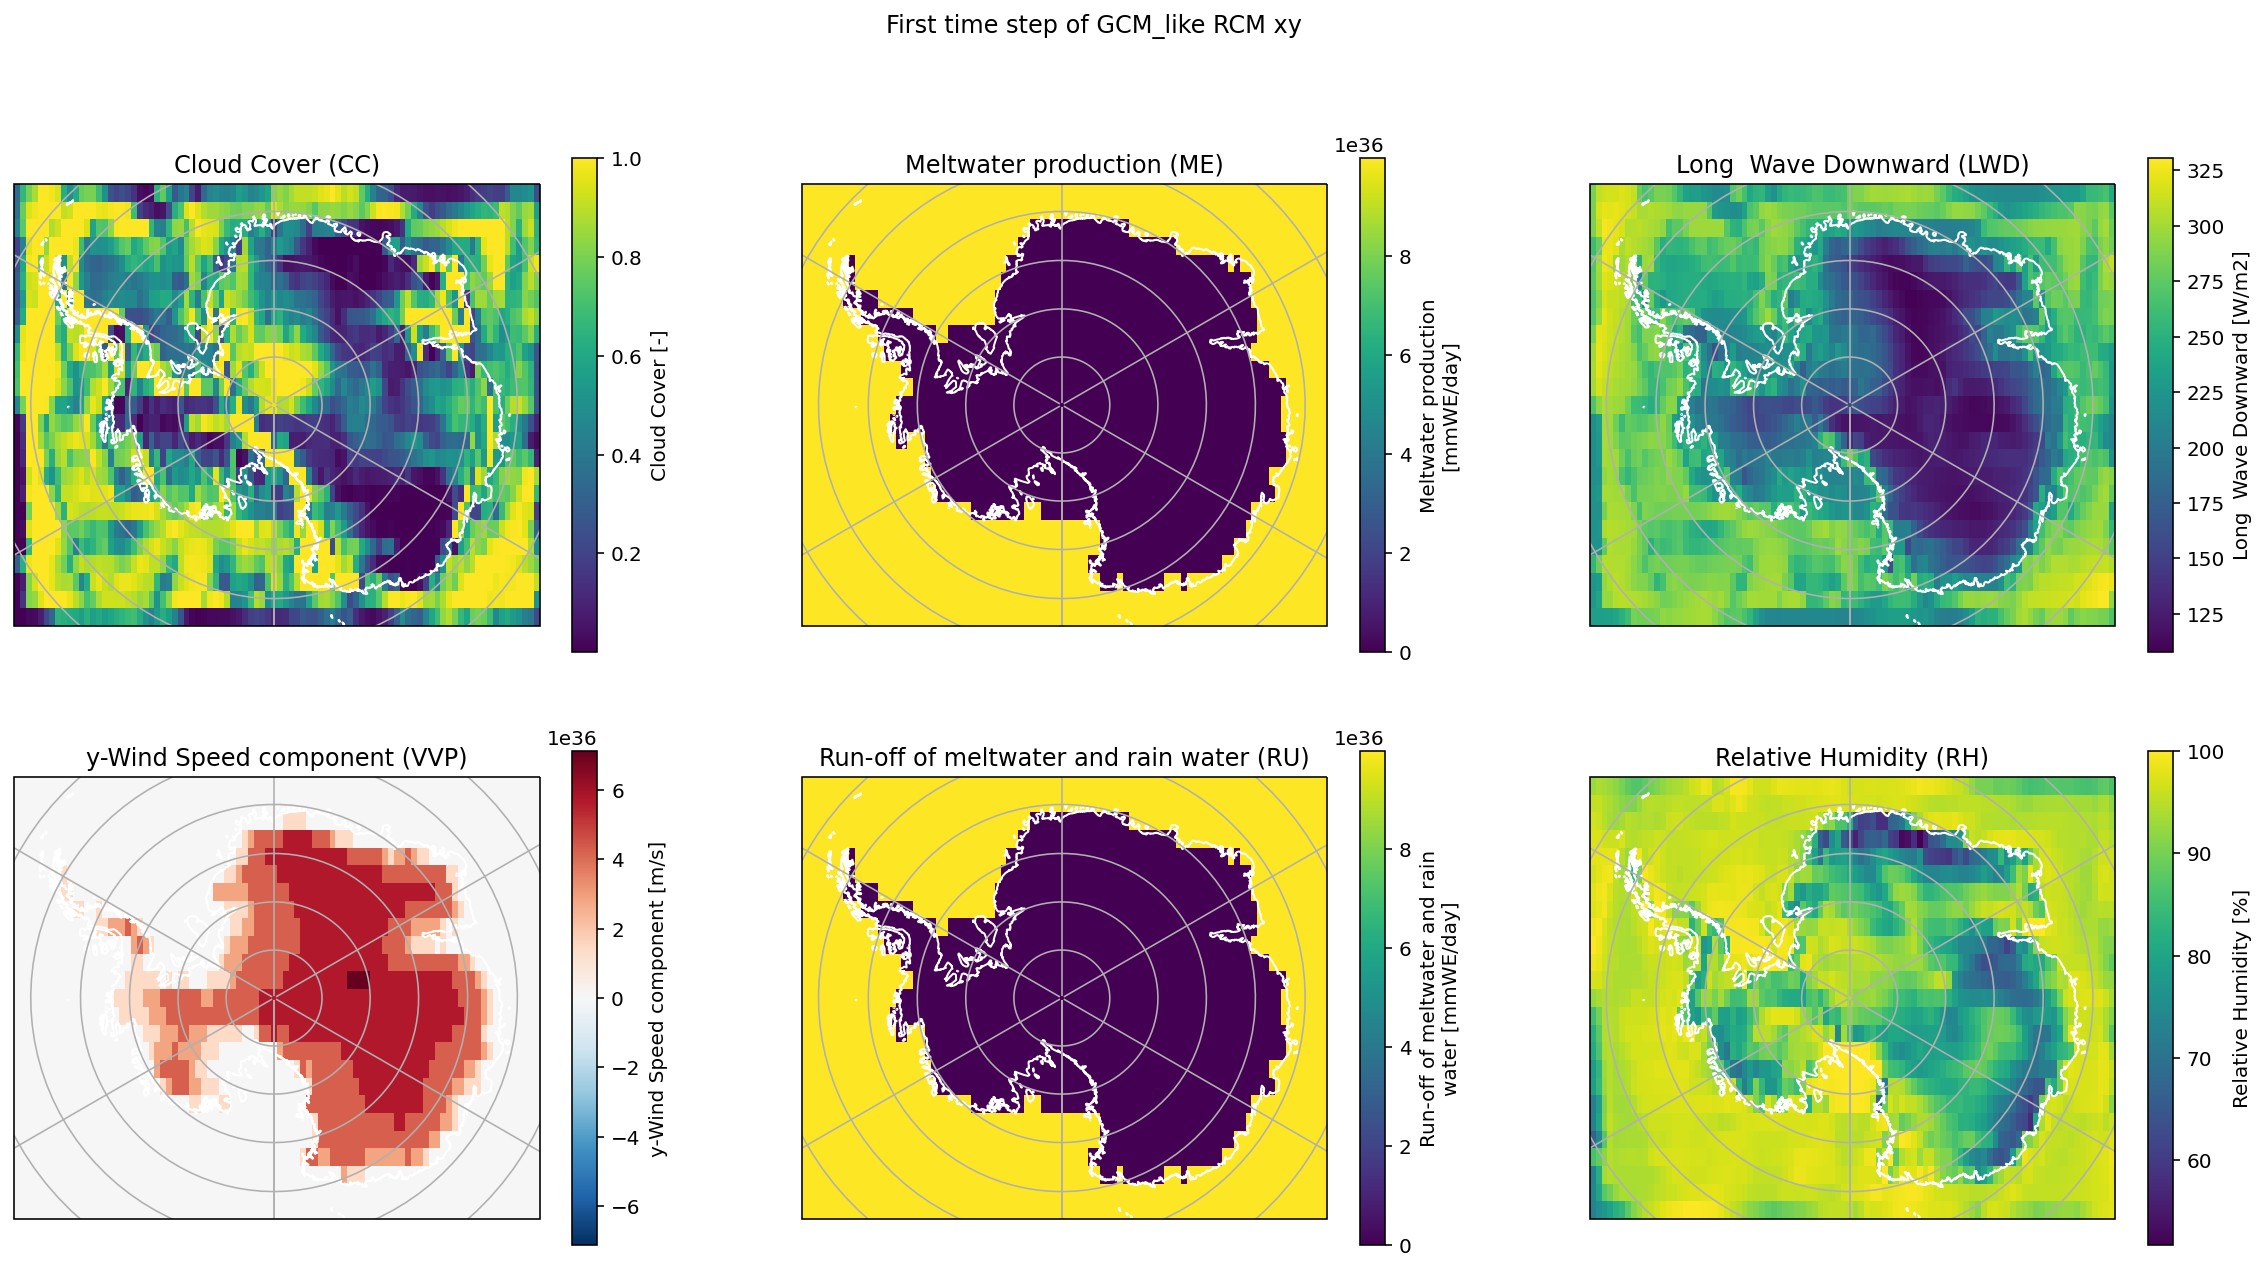

In [18]:
vars_ = list(GCM_like.keys())
coords = list(GCM_like.coords)

f = plt.figure(figsize=(20,10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(2,3,i+1,projection=ccrs.SouthPolarStereo())
    GCM_like[var].isel(time = 0).plot(ax=ax, 
                    x='x', y='y', 
                    transform=ccrs.SouthPolarStereo(),
                    add_colorbar=True
                   )
    ax.coastlines('10m', color='w')
    ax.set_title(f'{RCM_xy[var].long_name} ({var})')
    ax.gridlines()
plt.suptitle('First time step of GCM_like RCM xy')

In [19]:
print("GCM_like with crs x/y:\n----------------\n")
print_raster(GCM_like)

GCM_like with crs x/y:
----------------

shape: (25, 90)
resolution: (68000.0, 206000.0)
bounds: (-3026000.0, 2575000.0, 3094000.0, -2575000.0)
CRS: EPSG:3031

